# 2021 Nobel Prize Special

The physics Nobel this year was shared between three people, all experts in computational physics. This included a couple of climate/weather modellers that I had never heard of before, plus Giorgio Parisi at La Sapienza in Rome. 

In theory you guys are supposed to do a "mobility year" and go to study somewhere outside Luxembourg, I can recommmend Rome as a great city to eat out cheaply and well, and there are many good physicists at La Sapienza, not only Parisi.  Typically Nobel winners are shy about undergraduate teaching once they get their prize, so probably you have missed your chance to actually meet him, I don't know, maybe I am wrong.




## Kardar-Parisi-Zhang Equation

The KPZ equation is actually not much to do with Parisi's Nobel prize but it has the virtue of being something that is fairly important in basic computational physics, so I am going to do a special notebook this year introducing it.  The form is this:

$$
\frac{\partial h}{\partial t} = \nu \nabla^2 h + \frac{\lambda}{2} (\nabla h)^2 + \eta
$$

here $h(\vec{x},t)$ is some arbitrary field, typically pictured as the height of a surface above the x-y plane, equally it can be a potential in a space of any dimension, as the $\nabla^2$ operator is general to any Euclidean space (and maybe some others).

A nice physical picture here is if you imagine a lava lamp as it is starting to warm up, $h$ gives the height of the interface between the two fluids in the lamp above the heating plate at the base.  If $\nu$ is positive, then a regions of negative curvature (curvature is negative at the top of maxima) should be pulled back to the plate by surface tension.  If $\nu$ is negative, you have the phenomenon of "viscous fingering": small instabilities are magnified, like paint running down a wall.  If $\lambda$ is positive, instabilities drag along neighbouring regions of the surface, so viscous "fingers" can be quite fat; if $\lambda$ is negative then viscous fingers will quickly reach the minimum physical thickness, breaking off as droplets.  $\eta$ is uncorrelated Gaussian noise with variance $2D\delta_t$ picked independently for each time and space point, where $\delta_t$ is the time interval between noise being applied.



## KPZ Universality

We can characterise the "Universality Class" of the dynamics described by this equation by looking at the width of the fluctuations in $h$.  Define the width $W$:

$$
W(L,t) = \sqrt{ \left<   \frac{1}{L} \int_0^L  \left(h(l,T) - \bar{h}(t) \right)^2     \right>}
$$

Notice that $W$ is defined instantaneously, and for a given finite lengthscale of measurement $L$.

If a system falls inside the "KPZ Universality Class" then the fluctuations $W$ should obey the form:


$$
W(L,t) \approx DL^\alpha f(t / L^z)
$$

where: $f(u)=u^{\beta}$ $iff\,u>1$ otherwise $f(u)=1$.

Below is a short code implementing KPZ dynamics in 1D.

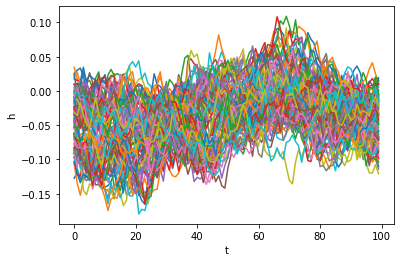

In [2]:
import numpy as np
import math
from   scipy import sparse
import matplotlib.pyplot as plt
%matplotlib inline

class KPZ_Class:
    """
    Class to store and update data for a Kardar-Parisi-Zhang system.
    """
    def __init__( self, N=100, dx=1.0, dt=1.0 ):
        """
        Setup to store the system state h[0..N]
        """
        self.N   = N
        self.h   = np.zeros((N))
        self.dx  = dx
        self.dt  = dt
        self.L   = N * self.dx
        self.age = 0
        
        ##build a matrix to find the second derivative by central difference.
        self.G2 = -2 * np.eye(N)
        for i in range(N):
            self.G2[i,(i+1)%N] = 1.0
            self.G2[i,(i-1)%N] = 1.0
        self.G2  = sparse.csr_matrix(self.G2) ##make a compact representation seeing as the matrix is mostly zeroes.
        self.G2 /= (self.dx*self.dx)
    
        ##first deriv:
        self.G = np.zeros((N,N))
        for i in range(N):
            self.G[i,(i+1)%N] =  0.5
            self.G[i,(i-1)%N] = -0.5
        self.G = sparse.csr_matrix(self.G)
        self.G2 /= self.dx
        
        ##store ongoing measurements of the W parameter
        self.W_values = []
        self.t_values = []
        
#    
#plt.imshow(G)
#plt.show()
#plt.cla()
#plt.imshow(G2)
#plt.show()
#plt.cla()
    
    def get_W(self):
        """get the interface width"""
        
        ##two-line implementation of the equation for W(L,t)
        dh  = self.h - np.mean(self.h)
        rms = np.sqrt( np.mean( np.multiply(dh, dh) ) * self.dx )
        
        return rms
            
        
    
    def update(self, nu, lamb_2, D, dt, n_steps = 1, n_save = 0):
        """
        Step forward, optionally saving data every n_save steps
        """
        stdDev  = np.sqrt(2*D*dt*self.dx) 
        
        for i in range(n_steps):
            grad    = self.G @ self.h
        
            ##simple implementation of KPZ equation for dh/dt
            dh_dt   = nu * ( self.G2 @ self.h ) 
            dh_dt  += lamb_2 * grad * grad 
            dh_dt  += np.random.normal(scale=stdDev, size=(self.N))
            
            ##simple Euler timestep
            self.h   += dh_dt * dt
            self.age += dt
            
            ##try not to go crazy saving too much data
            if len(self.t_values) == 0:
                self.W_values.append( self.get_W() )
                self.t_values.append( self.age )  
            elif n_save > 0:
                t_magnitude = math.log(len(self.t_values))
                if t_magnitude < 1: 
                    t_magnitude = 1
            
                if i % int(n_save * t_magnitude) == 0:
                    self.W_values.append( self.get_W() )
                    self.t_values.append( self.age )
        return

dt     =  0.1
nu     =  0.5
lamb_2 =  0.01 * 0.5
D      =  0.01
N      =   100

KPZ = KPZ_Class(N)

for i in range(100):
    KPZ.update(nu, lamb_2, D, dt, n_steps = 100, n_save = 0)
    plt.plot(np.arange(N), KPZ.h, label="%i" % i)
plt.xlabel("t")
plt.ylabel("h")
plt.show()
    




## Discussion of observed dynamics

Looking at the plot we can observe a couple of things, firstly there is a lot of noise inside a local envelope, which changes quite quickly and second we can see that the global shape of $h$ settles down early and is relatively very slow to change.

Lets try running for much longer:

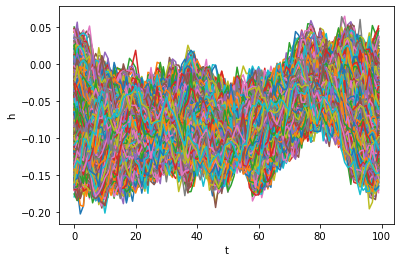

In [3]:

for i in range(1000):
    KPZ.update(nu, lamb_2, D, dt, n_steps = 10, n_save = 0)
    plt.plot(np.arange(N), KPZ.h, label="%i" % i)
plt.xlabel("t")
plt.ylabel("h")
plt.show()

OK!  This is still pretty bumpy, there is nothing special about any point in the space according to our dynamics, so over time everywhere should look the same...

working...
working... 0
working... 1000
working... 2000
working... 3000
working... 4000
working... 5000
working... 6000
working... 7000
working... 8000
working... 9000


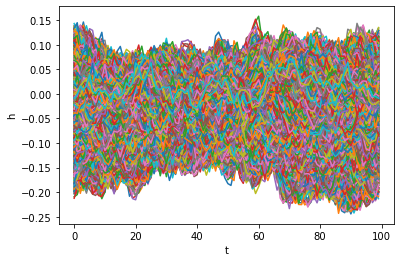

In [4]:
print("working...")
for i in range(10000):
    KPZ.update(nu, lamb_2, D, dt, n_steps = 10, n_save = 0)
    plt.plot(np.arange(N), KPZ.h, label="%i" % i)
    if i % 1000 == 0:
        print("working... %i" % i)
plt.xlabel("t")
plt.ylabel("h")
plt.show()

Well that took forever and it still isn't smooth.  Yes, KPZ dynamics are manifesting power law "disaster" statistics of the kind where the next event always still has a surprisingly big probablity to be bigger than anything seen before.

## Scaling Test

Computational physicists can keep busy by testing the conformity of a physical system to a given Universality.  Below we test if the KPZ system conforms to the KPZ universality:

running for L : 50


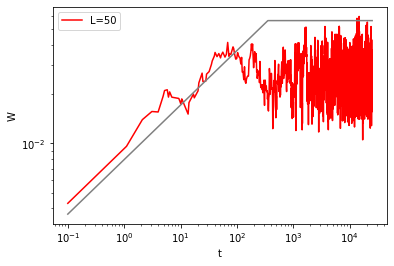

running for L : 100


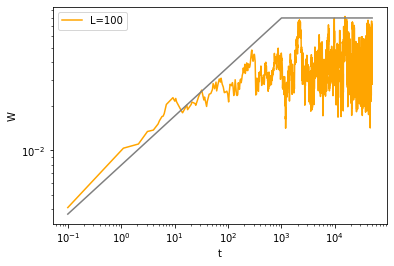

running for L : 200


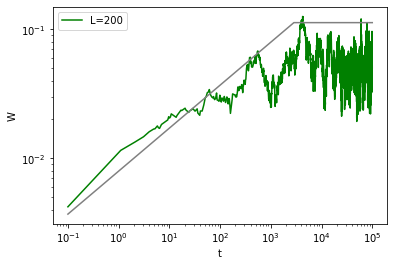

running for L : 400


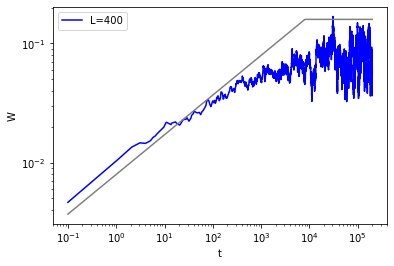

In [5]:
## Verification: delete this bit before uploading!

def expected_Wscale( tpts, L ):
    
    """return W(t,L) given KPZ universality class"""
    
    ##KPZ universality parameters
    alpha = 0.5
    beta  = 1.0/3.0
    z     = 1.5
    
    u     = (np.array(tpts) / (L**z) )
    for i, uval in enumerate(u):
        if uval > 1. : u[i] = 1.
    w = (L**alpha) * (u**beta)
    
    return w
    

plt.cla()
#plt.xlim([1,1000])
colors = ["red", "orange", "green", "blue", "pink", "black", "grey"]
for i_run, use_L in enumerate([50,100,200,400]):
    KPZ = KPZ_Class(use_L)
    print("running for L : %i" % use_L)
    KPZ.update(nu, lamb_2, D, dt, n_steps = 5000*use_L, n_save = 10)
    
    plt.loglog(KPZ.t_values, KPZ.W_values, label="L=%i" % use_L, color=colors[i_run%len(colors)])
    
    wScale  = expected_Wscale( KPZ.t_values, use_L )
    
    plt.loglog(KPZ.t_values, wScale*math.sqrt(D)/(4*math.pi), color="grey")#colors[i_run%len(colors)])
    plt.xlabel("t")
    plt.ylabel("W")
    plt.legend()
    plt.show()

Does the KPZ system obey KPZ universality?  This is pretty hard to prove, because the steady-state expectation of $W$ is only reached in infinite time.  Things do look good to me though.

# Assignment

Code up the following algorithm:

1. Define an (all-zero) array $h$ of size $L$
2. Choose a random cell $i$ of the array and add $1$ to the value.
3. Draw a random integer $x$ on $[1..M)$ where $M>>1$ is a parameter of the method.
4. If the difference in height between $h[i]$ and the value to the left (wrapping periodically) is greater than $x$, update the value to the left to be equal to $h[i]$, and go back to (3) this time for the newly updated cell.
5. Repeat 3-4, but this time going to the right of the original $i$.
6. Record the change in $h$ for this update.
7. Subtract the minimum value of $h$ from the system, such that at least one $h$-value will always be zero.
8. Back to $2$. Define $L$ updates ($L$ repeats of the loop 2..8) as one timestep.

I feel like the above system would probably satisfy KPZ universality, an obvious exercise would be to check that. I am more interested in seeing how effective it is as a simulator of physical earthquakes: does the "energy" released per "seismic event" (summed change in $h$ at a given update) follow a Gutenberg-Richter law, like real earthquakes?


## Task

1. Define the "event size" as the sum of all changes in $h$ made at that update, collect this (after equilibration) over a long time series for some value of $M$ and $L$ and plot the histogram on log-log axes.  Don't run all night, but do try to get a good few thousand datapoints.  I find $M=5$ and $L=100$ work fine as a demo that the code is working.

2. Make a plot showing multiple time series of $h$ to show that you have a handle on the equilibration time for your system.  Be aware that the equilibration time should increase with system size according to the KPZ equation if I am right (KPZ defines equilibration as being more-or-less reached at the location of the elbow in the predicted W values).

3. Make a plot showing multiple histograms of $h$ taken from equilibrated parts of time series, on the same axis, superimposed, exploring the behaviour (after equilibration) with increasing $L$, for $M=5$.  I used L=$10,100,1000$.

4. Write down an answer: does this rough qualitative model produce scaling in the "event size" similar to the Gutenberg-Richter law for earthquakes?


## Help for Task:

   
   I've asked you to plot some histograms.  Numpy provides a function for this, np.histogram(), but the syntax is not super convenient so I am going to give you a demo below.


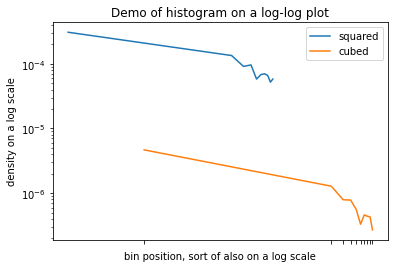

In [6]:
##getting a nice histogram trace on a log-log axis is actually pretty tricky, so 
##here is some example code.

import matplotlib.pyplot as plt
import numpy as np

def plot_logloghist( x, label ):
    bin_counts, bin_edges = np.histogram(x, density=True)

    N = len(bin_edges)
    log_bin_edges = np.log(bin_edges)
    bin_centres = 0.5 * (log_bin_edges[:N-1] + log_bin_edges[1:N])
    bin_labels  = np.exp(bin_centres)
    plt.yscale("log")
    plt.ylabel("density on a log scale")
    plt.xlabel("bin position, sort of also on a log scale")
    plt.plot(bin_centres, bin_counts, label=label)
    
    return bin_centres

##get some random numbers
a = np.random.random(1000)*100 
a = a**3  ##take the cube so that the distribution will look nice on a log-log plot
b = np.random.random(1000)*100 ##get some random numbers
b = b**2  

##make a plot
tics = plot_logloghist(b, "squared")
tics = plot_logloghist(a, "cubed")
plt.title("Demo of histogram on a log-log plot")
plt.xticks(tics, [])
plt.legend()
plt.show()


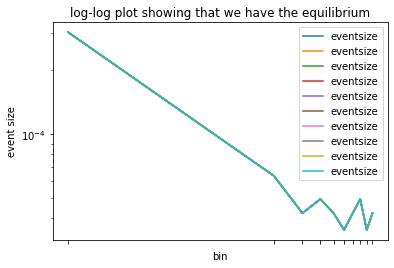

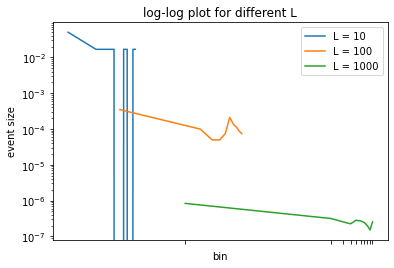

In [40]:
"""
    My attempt starts here
"""

## --- Libraries ---
import numpy as np
import matplotlib.pyplot as plt

## --- Function definition
def plot_logloghist( x, label ):
    bin_counts, bin_edges = np.histogram(x, density=True)

    N = len(bin_edges)
    log_bin_edges = np.log(bin_edges)
    bin_centres = 0.5 * (log_bin_edges[:N-1] + log_bin_edges[1:N])
    bin_labels  = np.exp(bin_centres)
    plt.yscale("log")
#     plt.ylabel("density on a log scale")
#     plt.xlabel("bin position, sort of also on a log scale")
    plt.plot(bin_centres, bin_counts, label=label)
    
    return bin_centres

def simulateEvent(L = 100, M = 5):

    height = np.zeros(L)
    eventSizeNumber = 0
    eventSize = [] ## sum of all h entries for a given timestep
    listM = []

    counter = 0
    while counter < L:
        counter += 1
        
        ## choosing a random entry and assigning value of one
        randomEntry = np.random.randint(0,L)
        height[randomEntry] += 1
        
        ## storing M for potential later use
        x = np.random.randint(1,M)
        listM.append(x)
        
        ## chain updating the height in both directions
        for i in range(len(height)):
            if (height[i]-height[i-1]>x):
                height[i-1] = height[i]
        
        for i in range(len(height)):
            if (height[len(height)-1]-height[0])>x:
                height[0] = height[len(height)-1]
            if i < len(height)-1:   
                if (height[i]-height[i+1])>x:
                    height[i+1] = height[i]
        
        ## substract minimum to have at least one zero entry
        heightMinimum = min(height)
        for i in range(len(height)):
            height[i]-= heightMinimum
        
        ## getting the actual event size
        for i in range(len(height)):
            eventSizeNumber += height[i]
        eventSize.append(eventSizeNumber)
        
    return eventSize, height

## --- Checking for equilibrium --- 
for i in range(10):
    equiEventSize,equiHeight = simulateEvent()
    tics = plot_logloghist(eventSize, "eventsize")
plt.title("log-log plot showing that we have the equilibrium")
plt.xticks(tics, [])
plt.xlabel("bin")
plt.ylabel("event size")
plt.legend()
plt.show()

## --- Testing grounds ---
eS1,h1 = simulateEvent(10)
eS2,h2 = simulateEvent()
eS3,h1 = simulateEvent(1000)

tics1 = plot_logloghist(eS1, "L = 10")
tics2 = plot_logloghist(eS2, "L = 100")
tics3 = plot_logloghist(eS3, "L = 1000")
plt.title("log-log plot for different L")
plt.xticks(tics1, [])
plt.xticks(tics2, [])
plt.xticks(tics3, [])
plt.xlabel("bin")
plt.ylabel("event size")
plt.legend()
plt.show()

## Answer
It does seem to follow a Gutenberg-Richter law for L = 100 and L = 10, but for L = 1000 we get very weird behaviour. Also, there is some roughness on the ends.